In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re

from sklearn.feature_extraction.text import CountVectorizer

import pymongo

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

from wordcloud import WordCloud,STOPWORDS 

# SETTING
plt.style.use('ggplot')
#display maximum column and rows
pd.options.display.max_columns = 999
pd.options.display.min_rows = 999
pd.options.display.max_colwidth = 500
stopword = STOPWORDS
stopword.add('im')
stopword.add('youre')


red = '#ef4b4b'
black = '#584b42'
green = '#a0cc78'
yellow_ = '#f6d365'
blue_ = '#49beb7'

#INIT


#METHODS
def sep():
    print(100*'-')

def connectMongoDB(dbname):
    client = pymongo.MongoClient('localhost', 27017)
    db = client[dbname]
    return db

dbname = 'clothing_fit'
db = connectMongoDB(dbname)

In [2]:
rent = list(db.rentCollection.find())
df_rent = pd.DataFrame(rent)

# MENGECEK NULL
df_rent.head(1)

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,"An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive


# Rating Feedback Analysis
- salah satu score yang akan digunakan adalah rating
- akan dilakukan analisa berdasarkan feedback rating terlebih dahulu

In [3]:
df_rent[df_rent['rating'].isnull()][['fit','sentiment_', 'review_summary']]
# karena 3 data null mendapat feedback positif (fit == fit dan sentiment == positif) -> sempurna 

,fit,sentiment_,review_summary


In [4]:
print(df_rent.rating.mode())
print(df_rent.rating.mean())
print(df_rent.rating.quantile(0.5))

0    10.0
dtype: float64
9.091925900034953
10.0


In [5]:
# mereplace null dengan angka 10 -> modus dan median + analisa feedback yang positif

df_rent.rating = df_rent.rating.fillna(10)
print("banyak data : ", len(df_rent))
sep()
print("angka null di rating :")
df_rent['rating'].isnull().sum()

banyak data :  20027
----------------------------------------------------------------------------------------------------
angka null di rating :


0

In [6]:
df_rent.head(1)

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,"An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive


<hr>

# Popularity Recommender System

1. Menentukan variabel yang diukur (rating) -> menunjukkan bahwa pakaian sudah pernah disewa dan diberi feedback, range(0 - 10)
2. Meghitung skor weighted rating pada tiap item, berdasarkan feeback yang diperoleh dari customer. 
3. Sort, item dengan hasil rating tertinggi akan menjadi top rekomendasi.

<hr>

## Weighted Rating 
### $$ WR = (\frac {v}{v+m} . R)+(\frac {m}{v+m}.C) $$


#### - R = rata-rata rating tiap item
#### - v = jumlah vote untuk masing2 item
#### - C = mean vote dari semua data yang tersedia
#### - m = minimum votes yang memenuhi syarat (treshold : persentil ke-90)


<hr>

# Mencari rata2 rating dari tiap Item Pakaian

### Item Pakaian dihitung berdasarkan id item x size, karena masing-masing ukuran akan merepresentasikan kecocokan customer yang berbeda

In [7]:
df_metadata = df_rent.groupby(['item_id','size']).mean()
df_metadata[['rating']].head(10)

rating
item_id size        
1000254 4       10.0
        8        8.0
        12      10.0
        16      10.0
        20       8.0
1000270 1       10.0
        4       10.0
        8       10.0
        12      10.0
        16       6.0

## Menghitung Jumlah Transaksi pada tiap Items

In [8]:
df_metadata['vote_count'] = df_rent.groupby(['item_id', 'size']).count()['rating']
df_metadata.describe()
# df_metadata.shape

,rating,height_cm,weight_kg,age_,vote_count
count,10973.000000,10973.000000,9778.000000,10973.000000,10973.000000
mean,9.072128,164.537466,63.027297,34.195516,1.825116
std,1.299958,6.365826,10.355388,7.591099,2.144213
min,2.000000,124.000000,41.000000,0.000000,1.000000
25%,8.000000,160.000000,56.333333,29.000000,1.000000
50%,10.000000,165.000000,61.000000,33.000000,1.000000
75%,10.000000,168.500000,68.000000,37.500000,2.000000
max,10.000000,190.000000,132.000000,117.000000,46.000000


In [9]:
# Calculate C (mean vote dari semua data yang tersedia)

C = df_metadata['rating'].mean()
print(C)

9.072128127021275


The average rating of items on RTR is around 9, on a scale of 10.

In [10]:
# Calculate the minimum number of votes required to be in the chart, m 
## persentil ke 90 dari angka vote keseluruhan data

m = df_metadata['vote_count'].quantile(0.90)
print(m)

3.0


Next, we can filter the clothes item that qualify for the chart, based on their vote counts:

## Memfilter item2 yang memiliki lebih dari angka mininum vote. dalam kasus ini persentil ke 90 = m = 3

In [11]:
print("sebelum filter : ", df_metadata.shape)

q_clothes = df_metadata.copy().loc[df_metadata['vote_count'] >= m]
print("setelah filter : ", q_clothes.shape)

sebelum filter :  (10973, 5)
setelah filter :  (1728, 5)


- ada 1726 item yang relevan untuk diajukan sebagai rekomendasi karena kepopuleran item.
- semua item dalam 1726 data ini sudah memenuhi batas sewa minimum untuk menjadi populer.
- item dianggap populer jika telah mencapai batas minimum kepopuleran yang didapat dari angka desil 9 dari data vote yang ada

In [12]:
q_clothes.head()

rating   height_cm  weight_kg       age_  vote_count
item_id size                                                         
1000739 8     10.000000  158.333333  57.000000  27.666667           3
1001122 16    10.000000  169.800000  64.750000  31.400000           5
1003076 8      9.500000  165.250000  62.000000  32.000000           4
        20    10.000000  167.000000  69.666667  29.500000           4
1005880 4      9.333333  166.000000  52.666667  33.666667           3

In [13]:
# Function that computes the weighted rating of each clothes

def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['rating']
    
    # Calculation based on the IMDB formula
    # jumlah Nvote * rating
    return (v/(v+m) * R) + (m/(m+v) * C)

In [14]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`

q_clothes['score'] = q_clothes.apply(weighted_rating, axis=1)
q_clothes.head()
# q_clothes.shape
# q_clothes

rating   height_cm  weight_kg       age_  vote_count  \
item_id size                                                            
1000739 8     10.000000  158.333333  57.000000  27.666667           3   
1001122 16    10.000000  169.800000  64.750000  31.400000           5   
1003076 8      9.500000  165.250000  62.000000  32.000000           4   
        20    10.000000  167.000000  69.666667  29.500000           4   
1005880 4      9.333333  166.000000  52.666667  33.666667           3   

                 score  
item_id size            
1000739 8     9.536064  
1001122 16    9.652048  
1003076 8     9.316626  
        20    9.602341  
1005880 4     9.202731

In [15]:
#Sort clothes-items based on score calculated above

q_clothes = q_clothes.sort_values('score', ascending=False)
q_clothes.tail()

,,rating,height_cm,weight_kg,age_,vote_count,score
item_id,size,,,,,,
1465348,14,6.000000,167.666667,63.333333,34.666667,3,7.536064
2201799,8,6.000000,168.000000,56.000000,30.333333,3,7.536064
124553,1,6.666667,163.500000,51.833333,32.333333,6,7.468487
144931,14,5.500000,162.500000,60.000000,31.500000,4,7.030912
1939556,4,4.666667,163.000000,51.500000,35.666667,3,6.869397


ini adalah scorre rating terrendah dari 410 data

# Rekomendasi Berdasarkan Rating dan Popularity

In [16]:
q_clothes.shape

(1728, 6)

In [17]:
def getPopRecom(num):
    return q_clothes.head(num)

getPopRecom(10)

rating   height_cm  weight_kg       age_  vote_count  \
item_id size                                                            
123793  5     10.000000  169.230769  58.076923  33.307692          13   
        13    10.000000  165.769231  65.333333  32.230769          13   
127865  8      9.913043  163.782609  58.500000  36.347826          23   
123793  1      9.900000  160.050000  51.684211  30.000000          20   
1449570 12    10.000000  162.555556  60.166667  32.111111           9   
1210233 8     10.000000  163.250000  62.600000  30.875000           8   
1260666 8     10.000000  162.375000  55.000000  35.375000           8   
730008  12    10.000000  164.500000  63.166667  31.750000           8   
123793  0     10.000000  154.375000  46.714286  28.375000           8   
195124  8     10.000000  162.142857  59.857143  32.714286           7   

                 score  
item_id size            
123793  5     9.826024  
        13    9.826024  
127865  8     9.816015  
123793  1     9.792017  
1449570 12    9.768032  
1210233 8     9.746944  
1260666 8     9.746944  
730008  12    9.746944  
123793  0     9.746944  
195124  8     9.721638

done

inilah hasil rekomendasi berdasarkan popularitas dan weighted rating
<hr>

<hr>

## Menyeleksi transaksi dg item yang mencapai persentil 90 ke atas

In [18]:
df_rent.columns.tolist()

['_id',
 'fit',
 'user_id',
 'bust size',
 'item_id',
 'weight',
 'rating',
 'rented for',
 'review_text',
 'body type',
 'review_summary',
 'category',
 'height',
 'size',
 'age',
 'review_date',
 'sentiment_',
 'height_cm',
 'weight_kg',
 'age_',
 'review_date_',
 'sentiment_summary',
 'sentiment_text']

In [19]:
# membuat df baru untuk memuat transaksi yang memuat item2 terfilter (persentil ke 90)

df_reco = pd.DataFrame(columns=df_rent.columns)

df_reco

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text


In [20]:
indexRecoitems = q_clothes.index
# print(indexRecoitems)
indexRecoitems = (list(indexRecoitems))
indexRecoitems = list(map(lambda x : x[0] + ", "+ str(x[1]) , indexRecoitems))
indexRecoitems

['123793, 5',
 '123793, 13',
 '127865, 8',
 '123793, 1',
 '1449570, 12',
 '1210233, 8',
 '1260666, 8',
 '730008, 12',
 '123793, 0',
 '195124, 8',
 '153475, 12',
 '1773356, 8',
 '1674806, 26',
 '131533, 21',
 '160612, 4',
 '123793, 2',
 '1420770, 16',
 '123793, 16',
 '1949394, 4',
 '162634, 12',
 '1869763, 12',
 '450618, 4',
 '1064397, 12',
 '1730006, 8',
 '1018841, 8',
 '1106101, 14',
 '1516843, 12',
 '362332, 12',
 '1542250, 39',
 '1031440, 20',
 '932347, 8',
 '1687082, 8',
 '131698, 8',
 '1213427, 13',
 '451969, 8',
 '124204, 4',
 '2595491, 14',
 '1213427, 16',
 '657626, 14',
 '1241304, 4',
 '1547971, 8',
 '1675905, 4',
 '139792, 8',
 '188052, 12',
 '123793, 21',
 '1335648, 12',
 '152662, 1',
 '144727, 45',
 '1001122, 16',
 '1497935, 8',
 '123793, 17',
 '1378631, 12',
 '2494898, 8',
 '136860, 28',
 '1744232, 20',
 '1746190, 12',
 '1186923, 8',
 '1831026, 16',
 '1919019, 8',
 '126335, 4',
 '730008, 4',
 '138431, 4',
 '123793, 8',
 '2752000, 12',
 '1610801, 8',
 '1980086, 8',
 '1163553

In [21]:
df_rent['item_id_size'] = df_rent['item_id'] + ', ' + df_rent['size'].astype('str')
df_rent.head(1)

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text,item_id_size
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,"An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive,"2260466, 14"


In [22]:
# memasukkan transaksi2 yang melibatkan item2 410 rekomendasi di dalam filter

for i in indexRecoitems:
#     print(df_rent[df_rent['item_id']==i])
    print(i)
    rekoi = pd.DataFrame(df_rent[df_rent['item_id_size']==i])
    print(len(rekoi))
    df_reco = pd.concat([df_reco,rekoi], axis=0)
    
df_reco.shape

123793, 5
13
123793, 13
13
127865, 8
23
123793, 1
20
1449570, 12
9
1210233, 8
8
1260666, 8
8
730008, 12

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  



8
123793, 0
8
195124, 8
7
153475, 12
7
1773356, 8
7
1674806, 26
7
131533, 21
7
160612, 4
7
123793, 2
7
1420770, 16
7
123793, 16
7
1949394, 4
7
162634, 12
6
1869763, 12
6
450618, 4
6
1064397, 12
6
1730006, 8
6
1018841, 8
6
1106101, 14
6
1516843, 12
6
362332, 12
6
1542250, 39
6
1031440, 20
6
932347, 8
6
1687082, 8
6
131698, 8
6
1213427, 13
6
451969, 8
6
124204, 4
12
2595491, 14
5
1213427, 16
5
657626, 14
5
1241304, 4
5
1547971, 8
5
1675905, 4
5
139792, 8
5
188052, 12
5
123793, 21
5
1335648, 12
5
152662, 1
5
144727, 45
5
1001122, 16
5
1497935, 8
5
123793, 17
5
1378631, 12
5
2494898, 8
5
136860, 28
5
1744232, 20
5
1746190, 12
5
1186923, 8
5
1831026, 16
5
1919019, 8
5
126335, 4
21
730008, 4
10
138431, 4
10
123793, 8
25
2752000, 12
4
1610801, 8
4
1980086, 8
4
1163553, 8
4
1821947, 8
4
1982904, 4
4
1687082, 9
4
1630499, 8
4
1516843, 1
4
194182, 12
4
2444721, 8
4
254493, 12
4
1213427, 12
4
1523882, 4
4
2546911, 8
4
188052, 16
4
2829293, 12
4
2829293, 8
4
155820, 4
4
155735, 16
4
263699, 12
4


(8661, 24)

In [23]:
# df_reco ini adalah df yang berisi 9683 data. yaitu data yang terdapat 410 item rekomendasi populer

df_reco.shape

(8661, 24)

# ada 8652 transaksi yang telah melibatkan 1726 recommended popular items

## Eksport DataFrame yang Memuat 1726 Items (persentil ke-90 ke atas)

In [24]:
# df_reco.to_csv('df_reco_410_item.csv')
df_reco.to_csv('df_reco_1726_item.csv')

In [25]:
df_reco = pd.read_csv('df_reco_1726_item.csv')

print(df_reco.shape)
df_reco.isnull().sum()

(8661, 25)


Unnamed: 0              0
_id                     0
age                    35
age_                    0
body type             513
bust size             823
category                0
fit                     0
height                 27
height_cm               0
item_id                 0
item_id_size            0
rating                  0
rented for              0
review_date             0
review_date_            0
review_summary          9
review_text             4
sentiment_              0
sentiment_summary       0
sentiment_text          0
size                    0
user_id                 0
weight               1392
weight_kg            1392
dtype: int64

In [26]:
# sekilas mengetahui kondisi data body type awal 

print("jumlah unik value : ",df_rent['body type'].nunique())
# ada 7, nan tidak dihiitung guys
print(df_rent['body type'].isnull().sum())
df_rent['body type'].unique().tolist()


jumlah unik value :  7
1510


['hourglass',
 'straight & narrow',
 nan,
 'pear',
 'athletic',
 'full bust',
 'petite',
 'apple']

# Body Type

In [27]:
print("jumlah tanpa nan : ",df_reco.groupby('body type').count()[['item_id']].sum()[0])
# ada 589 nan body type di dalam data
print('jumlah nan : ',df_reco['body type'].isnull().sum())
df_reco.groupby('body type').count()[['item_id']]

jumlah tanpa nan :  8148
jumlah nan :  513


,item_id
body type,
apple,186
athletic,2107
full bust,662
hourglass,2503
pear,985
petite,1084
straight & narrow,621


In [28]:
# df_reco_bodyshape  merupakan df_reco yang sudah siap untuk dipakai untuk rekomendasi berdasarkan bodyshape

df_reco_bodyshape = df_reco.dropna(subset=['body type'])

print("banyak data : ", len(df_reco_bodyshape))
df_reco_bodyshape.isnull().sum()

banyak data :  8148


Unnamed: 0              0
_id                     0
age                    19
age_                    0
body type               0
bust size             611
category                0
fit                     0
height                 25
height_cm               0
item_id                 0
item_id_size            0
rating                  0
rented for              0
review_date             0
review_date_            0
review_summary          9
review_text             4
sentiment_              0
sentiment_summary       0
sentiment_text          0
size                    0
user_id                 0
weight               1182
weight_kg            1182
dtype: int64

### saat ini ada df_reco_bodyshape -> 9094 data yang siap dijadikan acuan terhadap rekomendasi berdasarkan jenis bentuk badan

<hr>
<hr>

# RENTED FOR

In [29]:
print("jumlah value unik : ", df_rent['rented for'].nunique())
sep()
print('jumlah mula-mula : ', len(df_reco))
print("jumlah tanpa nan : ",df_reco.groupby('rented for').count()[['item_id']].sum()[0])
print("ada nan : ", df_reco['rented for'].isnull().sum() )
df_reco.groupby('rented for').count()[['item_id']]

jumlah value unik :  8
----------------------------------------------------------------------------------------------------
jumlah mula-mula :  8661
jumlah tanpa nan :  8661
ada nan :  0


,item_id
rented for,
date,266
everyday,219
formal affair,2222
other,716
party,1751
vacation,123
wedding,3116
work,248


In [30]:
# mengilangkan nan

df_reco_rentedfor = df_reco.dropna(subset=['rented for'])
df_reco_rentedfor.shape

(8661, 25)

## df_reco_rentedfor => 9682 data yang siap dijadikan acuan terhadap rekomendasi berdasarkan keperluan menyewa

<hr>
<hr>

# Rented For X Body Type

In [31]:
print('jumlah mula-mula : ', len(df_reco_bodyshape))
print("jumlah tanpa nan : ",df_reco_bodyshape.groupby('rented for').count()[['item_id']].sum()[0])
print("ada nan : ", df_reco_bodyshape['rented for'].isnull().sum() )


df_reco_bodyshape.groupby('rented for').count()[['item_id']]

jumlah mula-mula :  8148
jumlah tanpa nan :  8148
ada nan :  0


,item_id
rented for,
date,253
everyday,207
formal affair,2098
other,676
party,1659
vacation,118
wedding,2903
work,234


# Body Shape x Rented For

In [32]:
print('jumlah mula-mula : ', len(df_reco_rentedfor))
print("jumlah tanpa nan : ",df_reco_rentedfor.groupby('body type').count()[['item_id']].sum()[0])
print("ada nan : ", df_reco_rentedfor['body type'].isnull().sum() )


df_reco_rentedfor.groupby('body type').count()[['item_id']]

jumlah mula-mula :  8661
jumlah tanpa nan :  8148
ada nan :  513


,item_id
body type,
apple,186
athletic,2107
full bust,662
hourglass,2503
pear,985
petite,1084
straight & narrow,621


In [33]:
# ternyata dibolakbalik sama saja
df_reco_bodyshape_rentedfor = df_reco_bodyshape.dropna(subset=['rented for'])
df_reco_bodyshape_rentedfor.shape

(8148, 25)

## df_reco_bodyshape_rentedfor => 8139 data yang siap dijadikan acuan terhadap rekomendasi berdasarkan keperluan menyewa dan bentuk badan

<hr>
<hr>

# rating insight

In [34]:
# sekilas mengetahui kondisi rating type awal 

print("jumlah unik value : ",df_rent['rating'].nunique())

jumlah unik value :  5


In [35]:
# melihat kondisi rating

df_reco.groupby('rating').count()[['item_id']]
# df_reco.head()

,item_id
rating,
2.0,29
4.0,132
6.0,412
8.0,2420
10.0,5668


### Terdapat semua jenis rating di dalam df_reco
<hr>

In [36]:
df_reco_bodyshape_rentedfor.groupby('rating').count()[['item_id']]

,item_id
rating,
2.0,28
4.0,128
6.0,396
8.0,2291
10.0,5305


### Terdapat semua jenis rating juga di dalam df_reco_bodyshape_rentedfor
<hr>

# category insight

In [37]:
# sekilas mengetahui kondisi rating type awal 

print("jumlah unik value : ",df_rent['category'].nunique())
df_rent['category'].unique()

jumlah unik value :  57


array(['romper', 'gown', 'sheath', 'dress', 'leggings', 'top', 'jumpsuit',
       'sweater', 'jacket', 'shirtdress', 'maxi', 'shift', 'pants',
       'shirt', 'mini', 'skirt', 'pullover', 'blouse', 'suit', 'coat',
       'trench', 'bomber', 'cape', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'culottes', 'down',
       'trouser', 'midi', 'pant', 'legging', 'print', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'kaftan', 'overalls', 'jogger', 'tee',
       'combo', 'henley', 'cami', 'blouson', 'turtleneck', 'trousers',
       'overcoat', 'hoodie', 't-shirt', 'caftan'], dtype=object)

In [38]:
# melihat kondisi kategori
print("kategori yang muncul dalam df_reco : ", len(df_reco.groupby('category')))

df_reco.groupby('category').count()[['item_id']]
# df_reco.head()

kategori yang muncul dalam df_reco :  26


,item_id
category,
blazer,9
coat,9
dress,4286
frock,24
gown,2340
jacket,14
jumpsuit,161
knit,3
legging,9


# Kategori yang paling Banyak Muncul dalam 1726 top items

In [39]:
# melihat kondisi kategori
print("kategori yang muncul dalam df_reco_bodyshape_rentedfor : ", len(df_reco_bodyshape_rentedfor.groupby('category')))

df_reco_bodyshape_rentedfor.groupby('category').count()[['item_id']].sort_values('item_id', ascending=False)
# df_reco.head()

kategori yang muncul dalam df_reco_bodyshape_rentedfor :  26


,item_id
category,
dress,4024
gown,2214
sheath,885
shift,266
mini,195
maxi,154
jumpsuit,148
romper,91
top,30


### Dari sini kita mendapatkan hanya ada 26 kategori yang berada dalam item filter rekomendasi 1726 atau yang sudah difilter by "keberadaan body shape dan rented for"

<hr>
<hr>

In [40]:
df_reco.groupby(['weight_kg']).count()['item_id']
df_reco.groupby(['weight_kg']).sum()
# df_reco.weight_kg.unique()

,Unnamed: 0,age,age_,height_cm,item_id,rating,size,user_id
weight_kg,,,,,,,,
32.0,19460,37.0,37.0,175.0,123793,10.0,21,886016
40.0,3479,29.0,29.0,157.0,1662825,10.0,4,120907
41.0,33786,91.0,91.0,403.0,2103069,26.0,4,1916361
43.0,142171,363.0,363.0,1576.0,4304842,90.0,16,5732035
44.0,157898,471.0,471.0,2472.0,6212794,136.0,24,5965792
45.0,446887,1397.0,1397.0,6892.0,29370302,402.0,123,23021440
46.0,208825,696.0,696.0,3143.0,10410715,178.0,40,9795855
47.0,136019,377.0,377.0,2020.0,8042882,120.0,20,6137738
48.0,1027903,3228.0,3228.0,15830.0,70967980,916.0,201,45633226


In [41]:
# df_reco.weight_kg.plot.bar()
# plt.show()

print("weight terkecil : ",df_reco.weight_kg.min())
print("weight terbesar : ",df_reco.weight_kg.max())
sep()
print("Height terkecil : ",df_reco.height_cm.min())
print("Height terbesar : ",df_reco.height_cm.max())

weight terkecil :  32.0
weight terbesar :  118.0
----------------------------------------------------------------------------------------------------
Height terkecil :  124.0
Height terbesar :  193.0


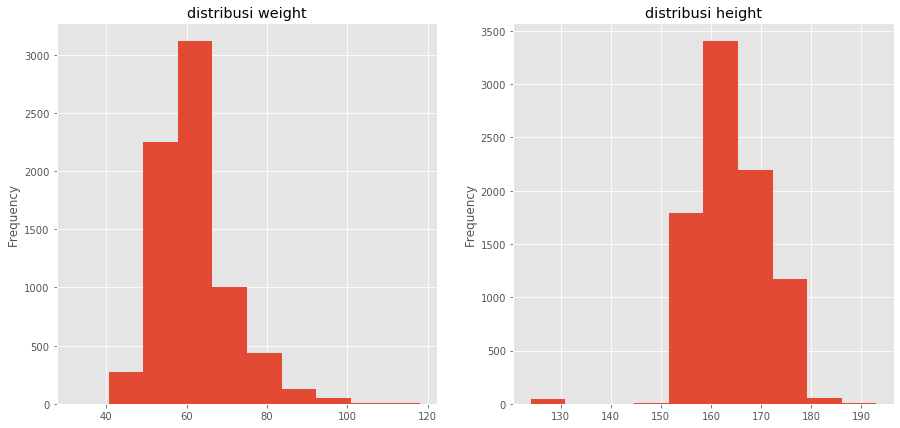

In [42]:
plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title('distribusi weight')
df_reco.weight_kg.plot.hist()

plt.subplot(122)
plt.title('distribusi height')
df_reco.height_cm.plot.hist()

In [43]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df_reco['weight_kg'] = df_reco['weight_kg'].fillna(0)
enc.fit(df_reco[['weight_kg']])
enc.categories_

[array([  0.,  32.,  40.,  41.,  43.,  44.,  45.,  46.,  47.,  48.,  49.,
         50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,  60.,
         61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
         83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
         94.,  95.,  96.,  98.,  99., 100., 102., 104., 107., 108., 109.,
        113., 116., 118.])]

In [44]:
df_rent.head()

,_id,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date,sentiment_,height_cm,weight_kg,age_,review_date_,sentiment_summary,sentiment_text,item_id_size
0,5e2ab8ce9f84980caca61bf7,fit,420272,34d,2260466,137lbs,10.0,vacation,"An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016",positive,173.0,62.0,28.0,2016-04-20,positive,positive,"2260466, 14"
1,5e2ab8ce9f84980caca61bf8,fit,273551,34b,153475,132lbs,10.0,other,"I rented this dress for a photo shoot. The theme was ""Hollywood Glam and Big Beautiful Hats"". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event.",straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013",positive,168.0,60.0,36.0,2013-06-18,positive,positive,"153475, 12"
2,5e2ab8ce9f84980caca61bf9,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a perfect dress for my event and I received so many compliments on it. Not to mention customer service was great getting this to me in less than 24 hours!,NaN,It was a great time to celebrate the (almost) completion of my first year of law school.,sheath,"5' 4""",4,116,"December 14, 2015",positive,163.0,NaN,116.0,2015-12-14,positive,positive,"1063761, 4"
3,5e2ab8ce9f84980caca61bfa,fit,909926,34c,126335,135lbs,8.0,formal affair,"I rented this for my company's black tie awards banquet. I liked that this dress was short but was a little fancier with the sequins. (I generally don't care for long dresses.) I would describe the color as more rose gold than yellow gold. I have blonde hair and fair skin, and the color was very flattering. This is a very forgiving dress! It's form fitting without making you feel like you're squeezed into it. I would rent this one again. Highly recommend!",pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014",positive,165.0,61.0,34.0,2014-02-12,positive,positive,"126335, 8"
4,5e2ab8ce9f84980caca61bfb,fit,151944,34b,616682,145lbs,10.0,wedding,"I have always been petite in my upper body and extremely athletic. \nI'm 5'9 and typically am a size 4,6,8 due to the fact I had a smaller upper frame and 34B cup. Depends what fabric were talking about too! \nHowever, because I have been lifting weights my back has grown (odd to add- but figured I'd say it knowing other people lift weights) My lat area is so wide that I was suffocating in a size 6. If I wasn't as muscular in my back I would've been fine. I would recommend to go up a size if...",athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016",positive,175.0,66.0,27.0,2016-09-26,positive,positive,"616682, 12"


In [45]:
# Build Recommendation Based on Body Shape and Categories
